# SVM Model Script for CS464 Term Project

## Data and Imports

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import os
import math
from google.colab import drive
import numpy as np
from sklearn.svm import SVC
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import cv2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, fbeta_score, ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
import time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
root_dir = "/content/drive/My Drive/CS464_project/processed_images"
os.listdir(root_dir)

In [ ]:
root_dir = "/content/drive/My Drive/processed_images"
os.listdir(root_dir)

['train', 'val', 'test']

In [ ]:
original_train_path = os.path.join(root_dir,"train","original")
original_val_path = os.path.join(root_dir,"val")
original_test_path = os.path.join(root_dir,"test")

aug_train_path = os.path.join(root_dir,"train","augmented")

In [ ]:
original_val_path

'/content/drive/My Drive/processed_images/val'

In [ ]:
classes = {'normal': 0, 'tumor': 1}

Training with original data

In [ ]:
# Original Training Set
x_train = []
y_train = []
is_gray_scale = True # RGB ÇÖP --> grayscale ile daha kısa zamanda aynı accuracy alınabiliyor!!
for cls in classes:
  train_pth = os.path.join(original_train_path, cls)
  for j in os.listdir(train_pth):
    image_path = os.path.join(train_pth,j)
    img = cv2.imread(image_path)
    if is_gray_scale:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = img.reshape((50176))
    else:
      img = img.reshape((50176*3))
    x_train.append(img)
    y_train.append(classes[cls])

#print(len(x_train))
#print(len(y_train))

In [ ]:
# Original Validation Set
x_val = []
y_val = []
is_gray_scale = True
for cls in classes:
  val_pth = os.path.join(original_val_path, cls)
  for j in os.listdir(val_pth):
    image_path = os.path.join(val_pth,j)
    img = cv2.imread(image_path)
    if is_gray_scale:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = img.reshape((50176))
    else:
      img = img.reshape((50176*3))
    x_val.append(img)
    y_val.append(classes[cls])

In [ ]:
# Original Test Set
x_test = []
y_test = []
is_gray_scale = True
for cls in classes:
  test_pth = os.path.join(original_test_path, cls)
  for j in os.listdir(test_pth):
    image_path = os.path.join(test_pth,j)
    img = cv2.imread(image_path)
    if is_gray_scale:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = img.reshape((50176))
    else:
      img = img.reshape((50176*3))
    x_test.append(img)
    y_test.append(classes[cls])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train.shape, x_test.shape

((767, 50176), (165, 50176))

Feature Scaling


In [ ]:
x_train = x_train /255
x_val = x_val /255
x_test = x_test /255

## Model

In [ ]:
model = SVC(max_iter = 700)
model.fit(x_train, y_train)

SVC(max_iter=700)

In [ ]:
print("Training Score:", model.score(x_train, y_train))
print("Validation Score:", model.score(x_val, y_val))

Training Score: 0.9921773142112125
Validation Score: 0.9575757575757575


In [ ]:
print("Grayscale Training Score:", model.score(x_train, y_train))
print("Grayscale Validation Score:", model.score(x_val, y_val))

Grayscale Training Score: 0.9921773142112125
Grayscale Validation Score: 0.9575757575757575


In [ ]:
pred = model.predict(x_val)

In [ ]:
pred.shape

(165,)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        61
           1       0.99      1.00      1.00       104

    accuracy                           0.99       165
   macro avg       1.00      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165



In [ ]:
accuracy_score(y_test, pred) # for 3 channelled RGB

0.9939393939393939

In [ ]:
accuracy_score(y_test, pred) # for gray scale

0.9939393939393939

In [ ]:
confusion_matrix(y_test, pred)

array([[ 60,   1],
       [  0, 104]])

In [ ]:
misclassified=np.where(y_test!=pred) 
misclassified
print("Total Misclassified Samples: ",len(misclassified[0]))

Total Misclassified Samples:  1


GridSearch Implementation for best parameters

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(x_train, y_train)  

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(x_test)
print(classification_report(y_test, grid_predictions))

In [ ]:
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [0.01, 0.001],
              'kernel': ['rbf']} 
train_indices = np.arange(len(x_train))
val_indices = len(x_train) + np.arange(len(x_val))
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, scoring = "roc_auc", cv = ((train_indices,val_indices),))
grid.fit(np.concatenate((x_train, x_val), axis =0),np.concatenate((y_train, y_val), axis =0))

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.992 total time=  49.7s
[CV 1/1] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.978 total time=  40.7s
[CV 1/1] END .......C=1, gamma=0.01, kernel=rbf;, score=0.992 total time=  41.9s
[CV 1/1] END ......C=1, gamma=0.001, kernel=rbf;, score=0.993 total time=  39.1s
[CV 1/1] END ......C=10, gamma=0.01, kernel=rbf;, score=0.993 total time=  40.9s
[CV 1/1] END .....C=10, gamma=0.001, kernel=rbf;, score=0.994 total time=  41.1s


GridSearchCV(cv=((array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
       871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883,
       884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896,
       897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909,
       910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922,
       923, 924, 925, 926, 927, 928, 929, 930, 931])),),
             estimator=SVC(

Another grid search implementation

In [ ]:
def truncate(n):
  n = str(n)
  n = n[:5]
  return float(n)


In [ ]:
C_space = [0.1, 1, 10]
gamma_space = [0.1 ,0.01, 0.001]
kernel = "rbf"
results = {"model": [],"C":[],"gamma":[],"accuracy": [],"f2 score": [],"AUC score": [],"Run Time": []}
for C in C_space:
  for gamma in gamma_space:
    t1 = time.time()
    model = SVC(C = C, gamma = gamma, kernel = kernel, probability= True, max_iter = 1000)
    model.fit(x_train, y_train)
    t2 = time.time()
    val_pred = model.predict(x_val)
    val_pred_probs = model.predict_proba(x_val)[:,1]
    accuracy = accuracy_score(y_val, val_pred)
    AUC = roc_auc_score(y_val, val_pred_probs)
    f2 = fbeta_score(y_val, val_pred, beta = 2)
    run_time = truncate(t2-t1)
    results["model"].append(model)
    results["accuracy"].append(accuracy)
    results["f2 score"].append(f2)
    results["Run Time"].append(run_time)
    results["AUC score"].append(AUC)
    results["C"].append(C)
    results["gamma"].append(gamma)
    print("The model with C:{} and gamma:{} is trained in {} seconds".format(C,gamma, run_time))


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:0.1 and gamma:0.1 is trained in 218.1 seconds
The model with C:0.1 and gamma:0.01 is trained in 190.8 seconds
The model with C:0.1 and gamma:0.001 is trained in 183.0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:1 and gamma:0.1 is trained in 189.7 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:1 and gamma:0.01 is trained in 185.2 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:1 and gamma:0.001 is trained in 155.8 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:10 and gamma:0.1 is trained in 192.7 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:10 and gamma:0.01 is trained in 183.4 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The model with C:10 and gamma:0.001 is trained in 156.5 seconds


In [ ]:
results_df = pd.DataFrame(results)
results_df


,model,accuracy,f2 score,Run Time,AUC score,gamma,C
0,"SVC(C=0.1, gamma=0.1, max_iter=1000, probabili...",0.624242,0.892548,218.1,0.973066,0.100,0.1
1,"SVC(C=0.1, gamma=0.01, max_iter=1000, probabil...",0.624242,0.892548,190.8,0.991074,0.010,0.1
2,"SVC(C=0.1, gamma=0.001, max_iter=1000, probabi...",0.806061,0.941499,183.0,0.978234,0.001,0.1
3,"SVC(C=1, gamma=0.1, max_iter=1000, probability...",0.636364,0.895652,189.7,0.976824,0.100,1.0
4,"SVC(C=1, gamma=0.01, max_iter=1000, probabilit...",0.812121,0.937500,185.2,0.992484,0.010,1.0
5,"SVC(C=1, gamma=0.001, max_iter=1000, probabili...",0.969697,0.972763,155.8,0.993110,0.001,1.0
6,"SVC(C=10, gamma=0.1, max_iter=1000, probabilit...",0.648485,0.898778,192.7,0.976981,0.100,10.0
7,"SVC(C=10, gamma=0.01, max_iter=1000, probabili...",0.836364,0.944444,183.4,0.992953,0.010,10.0
8,"SVC(C=10, gamma=0.001, max_iter=1000, probabil...",0.969697,0.972763,156.5,0.994363,0.001,10.0


In [ ]:
results_df.sort_values(by = ["AUC score"], ascending = False)

,model,accuracy,f2 score,Run Time,AUC score,gamma,C
8,"SVC(C=10, gamma=0.001, max_iter=1000, probabil...",0.969697,0.972763,156.5,0.994363,0.001,10.0
5,"SVC(C=1, gamma=0.001, max_iter=1000, probabili...",0.969697,0.972763,155.8,0.993110,0.001,1.0
7,"SVC(C=10, gamma=0.01, max_iter=1000, probabili...",0.836364,0.944444,183.4,0.992953,0.010,10.0
4,"SVC(C=1, gamma=0.01, max_iter=1000, probabilit...",0.812121,0.937500,185.2,0.992484,0.010,1.0
1,"SVC(C=0.1, gamma=0.01, max_iter=1000, probabil...",0.624242,0.892548,190.8,0.991074,0.010,0.1
2,"SVC(C=0.1, gamma=0.001, max_iter=1000, probabi...",0.806061,0.941499,183.0,0.978234,0.001,0.1
6,"SVC(C=10, gamma=0.1, max_iter=1000, probabilit...",0.648485,0.898778,192.7,0.976981,0.100,10.0
3,"SVC(C=1, gamma=0.1, max_iter=1000, probability...",0.636364,0.895652,189.7,0.976824,0.100,1.0
0,"SVC(C=0.1, gamma=0.1, max_iter=1000, probabili...",0.624242,0.892548,218.1,0.973066,0.100,0.1


In [ ]:
results_df.drop("model", axis = 1).sort_values(by = ["AUC score"], ascending = False)

,accuracy,f2 score,Run Time,AUC score,gamma,C
8,0.969697,0.972763,156.5,0.994363,0.001,10.0
5,0.969697,0.972763,155.8,0.993110,0.001,1.0
7,0.836364,0.944444,183.4,0.992953,0.010,10.0
4,0.812121,0.937500,185.2,0.992484,0.010,1.0
1,0.624242,0.892548,190.8,0.991074,0.010,0.1
2,0.806061,0.941499,183.0,0.978234,0.001,0.1
6,0.648485,0.898778,192.7,0.976981,0.100,10.0
3,0.636364,0.895652,189.7,0.976824,0.100,1.0
0,0.624242,0.892548,218.1,0.973066,0.100,0.1


In [ ]:
best_model = results_df.values[8,0]
test_pred = best_model.predict(x_test)
test_pred_probs = model.predict_proba(x_test)[:,1]
accuracy = accuracy_score(y_test, test_pred)
AUC = roc_auc_score(y_test, test_pred_probs)
f2 = fbeta_score(y_test, test_pred, beta = 2)
print("Accuracy of the best model on the test set is:", accuracy)
print("AUC score of the best model on the test set is:", AUC)
print("F2 score of the best model on the test set is:", f2)

Accuracy of the best model on the test set is: 1.0
AUC score of the best model on the test set is: 1.0
F2 score of the best model on the test set is: 1.0


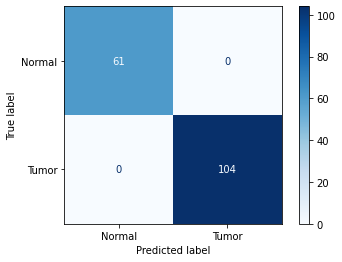

In [ ]:

cm = confusion_matrix(y_test,test_pred)
labels = ["Normal" , "Tumor"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()


#Part 2 - Multiclass and Binary(Benign and Malignant) Classifications
  ## Multiclass Classification

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import os
import math
from google.colab import drive
import numpy as np
from sklearn.svm import SVC
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import cv2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, fbeta_score, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import Normalizer
import time
import torch

In [ ]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


In [ ]:
classes = {"normal": 0, "benign" : 1, "malignant":2}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/CS464_project/part2images/"
os.listdir(root_dir)

['test', 'train', 'val']

In [ ]:
train_set = root_dir + "train"
validation_set = root_dir + "val"
test_set = root_dir + "test"

In [ ]:
x_train = []
y_train = []
count_benign = 0
count_malignant = 0
for j in os.listdir(train_set):
  image_path = os.path.join(train_set,j)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgArray = img.reshape((-1))
  x_train.append(imgArray)
  if "normal" in j:
    y_train.append(0)
  elif "benign" in j:
    count_benign+=1
    y_train.append(1)
  elif "malignant" in j:
    count_malignant+=1
    y_train.append(2)

In [ ]:
count_benign, count_malignant

(1413, 1809)

In [ ]:
x_train[:10], y_train[:10] 

([array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([0, 0, 0, ..., 0, 1, 0], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)],
 [1, 1, 1, 0, 2, 2, 0, 0, 0, 1])

In [ ]:
x_test = []
y_test = []
for j in os.listdir(test_set):
  image_path = os.path.join(test_set,j)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgArray = img.reshape((-1))
  x_test.append(imgArray)
  if "normal" in j:
    y_test.append(0)
  elif "benign" in j:
    y_test.append(1)
  elif "malignant" in j:
    y_test.append(2)

In [ ]:
count_benign, count_malignant

(1413, 1809)

In [ ]:
x_test[:10], y_test[:10] 

([array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([41, 41, 42, ..., 42, 43, 42], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
  array([38, 38, 38, ..., 38, 38, 38], dtype=uint8)],
 [2, 2, 2, 2, 2, 0, 2, 2, 0, 1])

In [ ]:
poly = SVC(kernel='poly', degree=3, C=1).fit(x_train, y_train)
# training çok uzun sürüyor....

In [ ]:
poly_pred = poly.predict(x_test)

In [ ]:
x_test

[array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([41, 41, 42, ..., 42, 43, 42], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38, ..., 38, 38, 38], dtype=uint8),
 array([38, 38, 38

In [ ]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average = None)
poly_f2 = fbeta_score(y_test, poly_pred, average = None, beta = 2)
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', poly_f1)
print('F2 (Polynomial Kernel): ', poly_f2)

Accuracy (Polynomial Kernel):  98.79
F1 (Polynomial Kernel):  [0.98387097 0.93333333 1.        ]
F2 (Polynomial Kernel):  [0.98387097 0.93333333 1.        ]


In [ ]:
poly_f2_macro = fbeta_score(y_test, poly_pred, average = "macro", beta = 2)
poly_f2_macro

0.9724014336917562

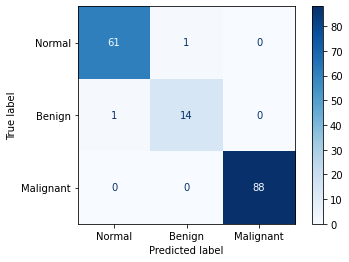

In [ ]:
cm = confusion_matrix(y_test,poly_pred)
labels = ["Normal", "Benign", "Malignant"] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Part 3 - Binary Classification for Malignant & Bening Tumors

In [ ]:
tumor_x_train = []
tumor_y_train = []
for j in os.listdir(train_set):
  image_path = os.path.join(train_set,j)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgArray = img.reshape((-1))
  if "benign" in j:
    tumor_y_train.append(1)
    tumor_x_train.append(imgArray)
  elif "malignant" in j:
    tumor_y_train.append(2)
    tumor_x_train.append(imgArray)

In [ ]:
tumor_x_test = []
tumor_y_test = []
for j in os.listdir(test_set):
  image_path = os.path.join(test_set,j)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgArray = img.reshape((-1))
  if "benign" in j:
    tumor_y_test.append(1)
    tumor_x_test.append(imgArray)
  elif "malignant" in j:
    tumor_y_test.append(2)
    tumor_x_test.append(imgArray)

In [ ]:
rbf = SVC(kernel='rbf', gamma=0.001, C=10).fit(tumor_x_train, tumor_y_train) # from the first part that we found the best parameters

In [ ]:
rbf_preds = rbf.predict(tumor_x_test)

In [ ]:
len(tumor_x_test)

103

In [ ]:
rbf_accuracy = accuracy_score(tumor_y_test, rbf_preds)
rbf_f1 = f1_score(tumor_y_test, rbf_preds)
rbf_f2 = fbeta_score(tumor_y_test, rbf_preds, beta = 2)
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))
print('F2 (RBF Kernel): ', "%.2f" % (rbf_f2*100))

Accuracy (RBF Kernel):  89.32
F1 (RBF Kernel):  42.11
F2 (RBF Kernel):  31.25


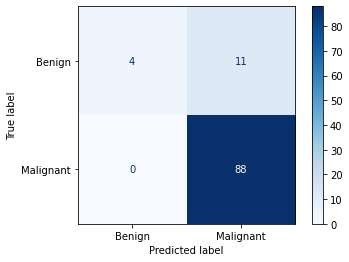

In [ ]:
cm = confusion_matrix(tumor_y_test,rbf_preds)
labels = ["Benign", "Malignant"] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()
